In [1]:
import sys
import pandas as pd
import numpy as np

# Add the project root directory to Python path
project_root = r'c:\Users\pedro.hun\Documents\repos\option_monitor2'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.orchestrators.df_creator import DFCreator
from src.orchestrators.single_expiry_fitting import SingleExpiry

In [2]:
df = DFCreator()
final_df = df.apply_greeks()

Could not adjust IV limits to bracket root
Market Price: 5.3149999999999995, Price at Low Vol: 0.0, Price at High Vol: 3.0070581335068254 for strike 24.4
Invalid price range for IV calculation
Could not adjust IV limits to bracket root
Market Price: 0.11, Price at Low Vol: 0.414020093962747, Price at High Vol: 5.300788999681185 for strike 30.15
Invalid price range for IV calculation
Could not adjust IV limits to bracket root
Market Price: 0.060000000000000005, Price at Low Vol: 0.6546942708216046, Price at High Vol: 5.404259376472127 for strike 30.4
Invalid price range for IV calculation
Could not adjust IV limits to bracket root
Market Price: 0.035, Price at Low Vol: 0.8914422784005485, Price at High Vol: 5.5077968143281435 for strike 30.65
Invalid price range for IV calculation
Could not adjust IV limits to bracket root
Market Price: 0.015, Price at Low Vol: 1.1243594120704452, Price at High Vol: 5.611376481622916 for strike 30.9
Invalid price range for IV calculation
Could not adjus

In [3]:
final_df[['IV', 'CalcIVOG', 'CalcIV']]

,IV,CalcIVOG,CalcIV
4,0.078125,NaN,NaN
10,0.381927,NaN,2.560281
13,0.230331,0.236196,0.962285
14,0.154781,0.213919,0.478977
15,0.218811,0.208108,0.269256
...,...,...,...
1889,0.280824,0.266525,NaN
1890,0.265405,0.276334,0.066390
1891,0.279446,0.275794,0.113061
1892,0.264764,0.277285,0.150478


Found 8 options with 3 days to expiry
Moneyness range: -0.022 to 0.028
Initial guess for SVI parameters: [np.float64(0.0005038393182959244), np.float64(0.006336344738584494), np.float64(-0.5), np.float64(-0.005721229450137556), 0.05]


c:\Users\pedro.hun\Documents\repos\option_monitor2\src\core\interpolation_single_expiry\svi_redo.py:153: OptimizeWarning: Unknown solver options: ftol, gtol
  p0 = sop.minimize(obj_fun, x0=initial_guess, method=method, bounds=bounds, options={'maxiter':10000, 'ftol':1e-8, 'gtol':1e-7})


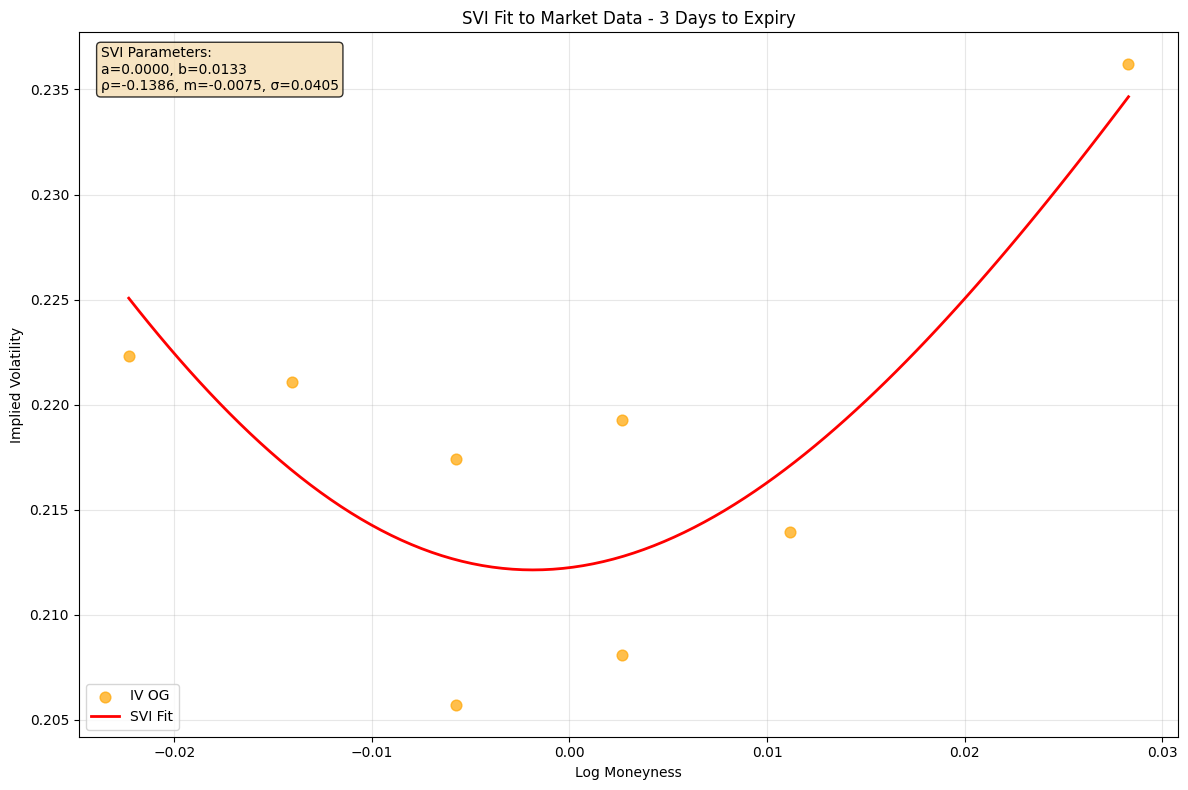

Found 11 options with 8 days to expiry
Moneyness range: -0.023 to 0.118
Initial guess for SVI parameters: [np.float64(0.0012929720968980886), np.float64(0.022923485868430387), np.float64(-0.5), np.float64(-0.006287076303446771), 0.05]


c:\Users\pedro.hun\Documents\repos\option_monitor2\src\core\interpolation_single_expiry\svi_redo.py:153: OptimizeWarning: Unknown solver options: ftol, gtol
  p0 = sop.minimize(obj_fun, x0=initial_guess, method=method, bounds=bounds, options={'maxiter':10000, 'ftol':1e-8, 'gtol':1e-7})


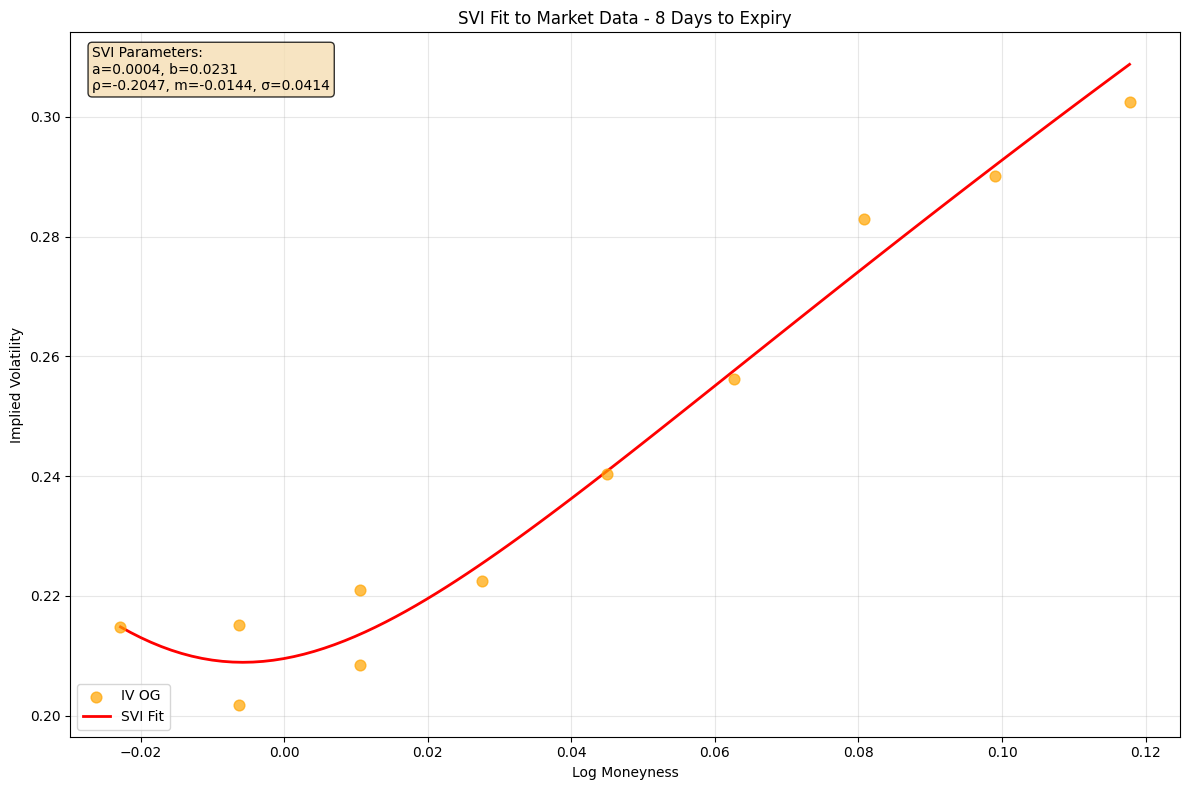

Found 6 options with 18 days to expiry
Moneyness range: -0.030 to 0.019
Initial guess for SVI parameters: [np.float64(0.004661734146334607), np.float64(0.11605292902847116), np.float64(-0.5), np.float64(-0.013986194229056503), 0.05]


c:\Users\pedro.hun\Documents\repos\option_monitor2\src\core\interpolation_single_expiry\svi_redo.py:153: OptimizeWarning: Unknown solver options: ftol, gtol
  p0 = sop.minimize(obj_fun, x0=initial_guess, method=method, bounds=bounds, options={'maxiter':10000, 'ftol':1e-8, 'gtol':1e-7})


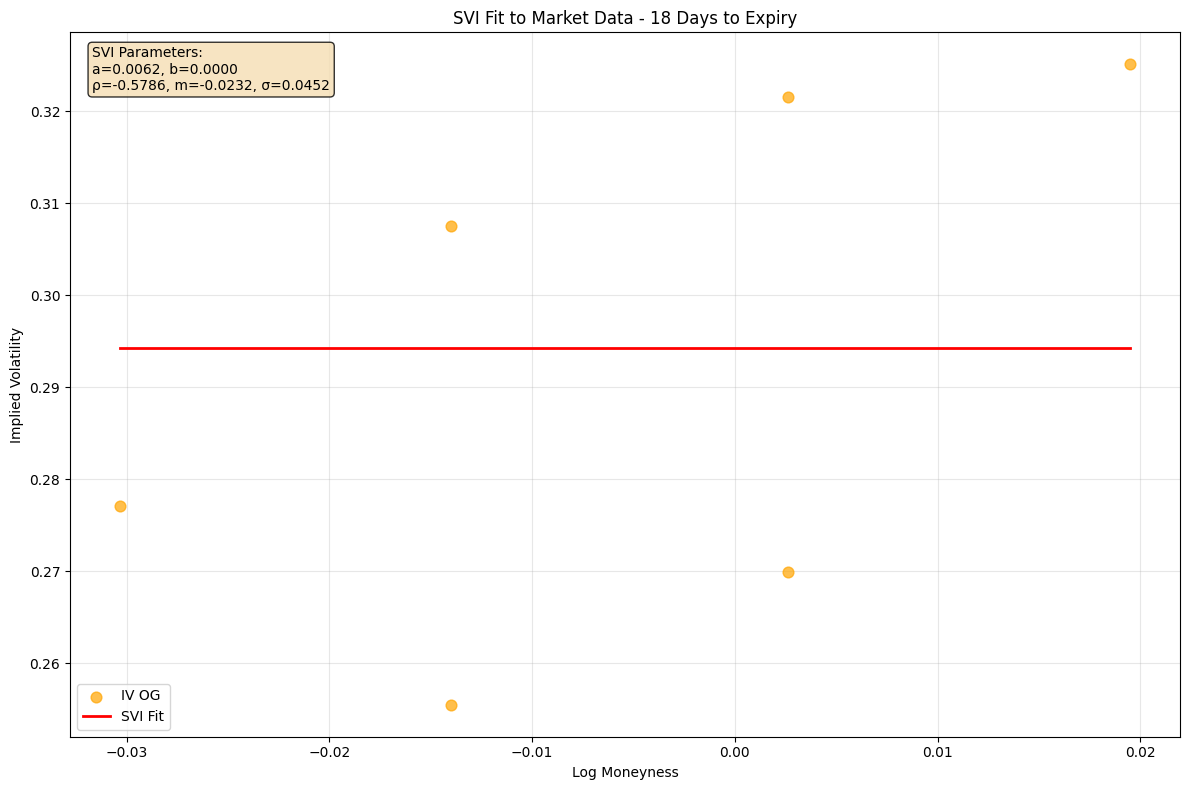

Found 39 options with 22 days to expiry
Moneyness range: -0.038 to 0.268
Initial guess for SVI parameters: [np.float64(0.005068087940149553), np.float64(0.0490108513244419), np.float64(-0.5), np.float64(-0.01406773528473356), np.float64(0.07671747459656979)]


c:\Users\pedro.hun\Documents\repos\option_monitor2\src\core\interpolation_single_expiry\svi_redo.py:153: OptimizeWarning: Unknown solver options: ftol, gtol
  p0 = sop.minimize(obj_fun, x0=initial_guess, method=method, bounds=bounds, options={'maxiter':10000, 'ftol':1e-8, 'gtol':1e-7})


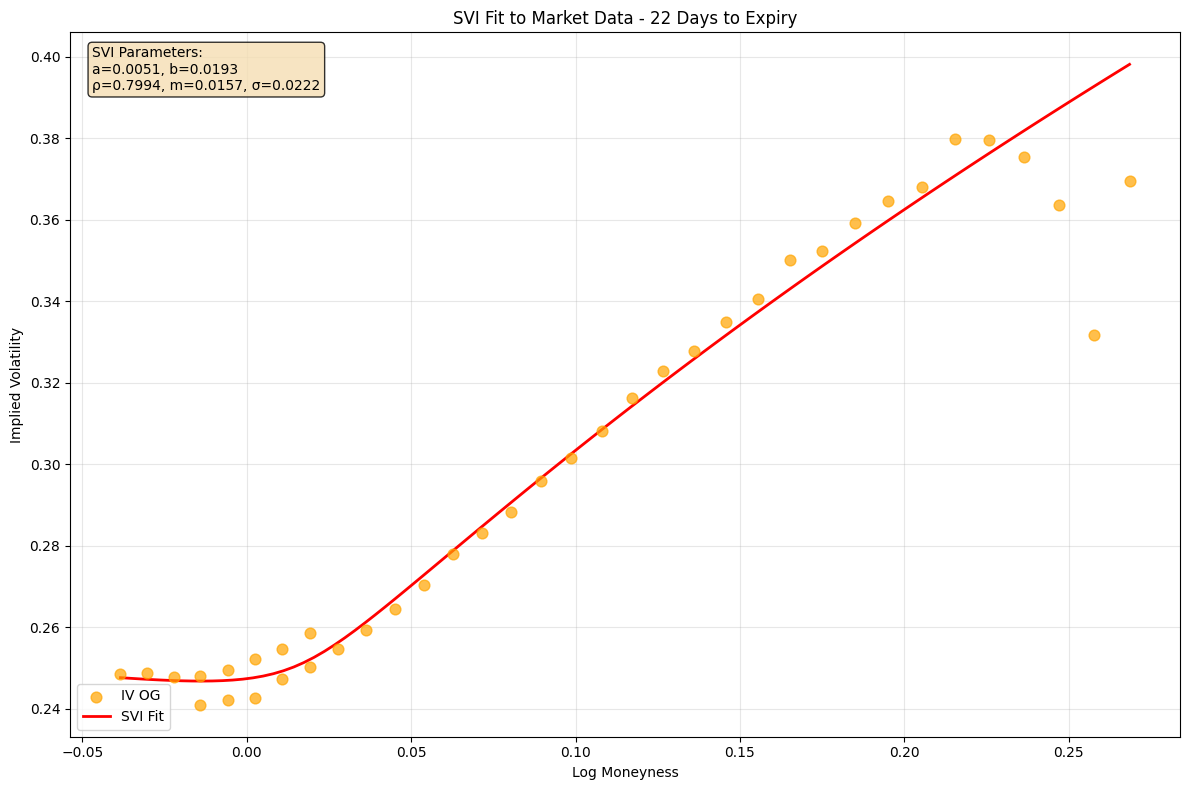

Found 5 options with 27 days to expiry
Moneyness range: -0.041 to 0.024
Initial guess for SVI parameters: [np.float64(0.005017140962658786), np.float64(0.13944413101507963), np.float64(0.5), np.float64(-0.00899469628708629), 0.05]


c:\Users\pedro.hun\Documents\repos\option_monitor2\src\core\interpolation_single_expiry\svi_redo.py:153: OptimizeWarning: Unknown solver options: ftol, gtol
  p0 = sop.minimize(obj_fun, x0=initial_guess, method=method, bounds=bounds, options={'maxiter':10000, 'ftol':1e-8, 'gtol':1e-7})


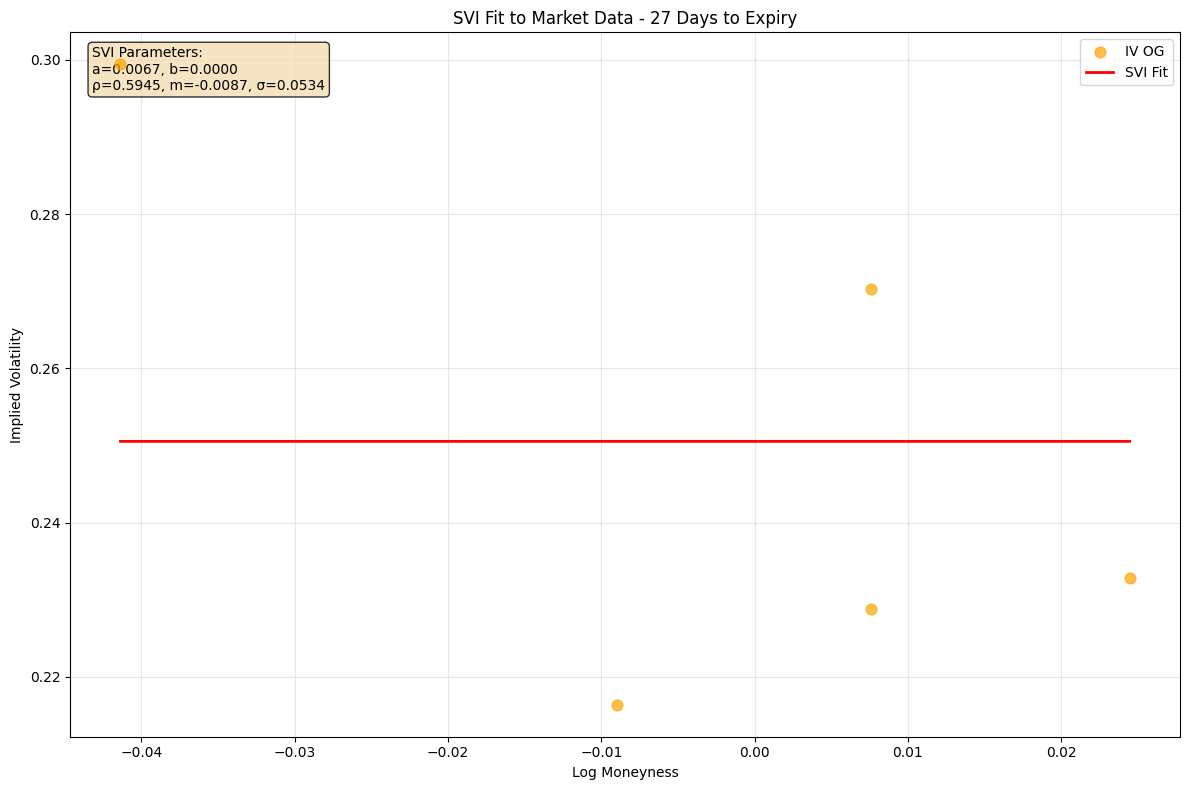

Found 47 options with 42 days to expiry
Moneyness range: -0.036 to 0.357
Initial guess for SVI parameters: [np.float64(0.009379470966872552), np.float64(0.05442759534811067), np.float64(-0.5), np.float64(-0.020220129123440175), np.float64(0.0984076626152904)]


c:\Users\pedro.hun\Documents\repos\option_monitor2\src\core\interpolation_single_expiry\svi_redo.py:153: OptimizeWarning: Unknown solver options: ftol, gtol
  p0 = sop.minimize(obj_fun, x0=initial_guess, method=method, bounds=bounds, options={'maxiter':10000, 'ftol':1e-8, 'gtol':1e-7})


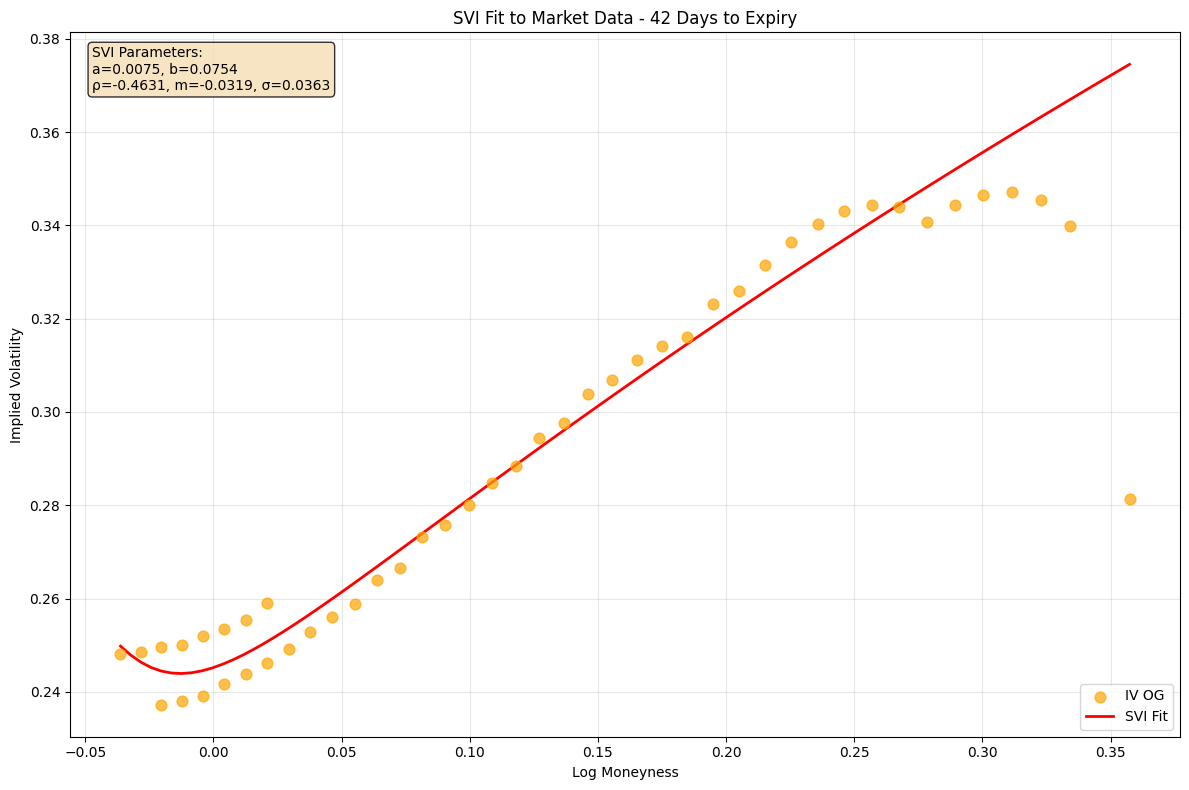

Found 1 options with 46 days to expiry
Moneyness range: 0.018 to 0.018
Initial guess for SVI parameters: [np.float64(0.006813833653531076), np.float64(nan), np.float64(0.0), np.float64(0.01812703849482993), 0.05]
SVI fitting failed: Input contains NaN.
Plotting failed: Input contains NaN.


c:\Users\pedro.hun\Documents\repos\option_monitor2\src\core\interpolation_single_expiry\svi_redo.py:134: RuntimeWarning: invalid value encountered in scalar divide
  max((np.max(w)-np.min(w))*2/((np.max(k) - np.min(k))), 1e-3),
c:\Users\pedro.hun\Documents\repos\option_monitor2\src\core\interpolation_single_expiry\svi_redo.py:153: OptimizeWarning: Unknown solver options: ftol, gtol
  p0 = sop.minimize(obj_fun, x0=initial_guess, method=method, bounds=bounds, options={'maxiter':10000, 'ftol':1e-8, 'gtol':1e-7})


ValueError: Input contains NaN.

In [4]:
final_df.dropna(inplace=True)
for x in final_df['TTE_days'].unique():
    fitting = SingleExpiry(days_to_expiry=x, df=final_df)
    fitting.plot_svi()